# Estimating type-I error rates using resting state datasets
Natalia Vélez, Psych 248 final project

## Introduction

The present notebook describes a method for detecting bias in analysis streams by analyzing resting state data. In general, analysis of fMRI data is highly idiosyncratic—preferred software packages, analytic steps, and procedures vary from lab to lab, and pipelines are typically stitched together using a combination of standardized software packages and in-house scripts. At each step of designing a task and building an analysis pipeline, the experimenter is faced with design decisions that may affect the validity of the final result. One way to address these questions is to explore the literature. A typical fMRI statistics paper might address the impact of a small set of parameters (such as study design, model structure, choice of software package, multiple comparisons correction method) on a small set of performance metrics (such as type-I and type-II error rates). Each paper, then, informs a small piece of the pipeline as a whole.

The ultimate goal of this project is to build a scaffold by which researchers can test and validate their own pipelines. As a starting point for this project, we were faced with two key  questions about its scope and design: (1) what performance metrics to use to evaluate a pipeline, and (2) what data to use to test the pipeline.

First, there are many possible criteria by which a given pipeline might be considered 'better' or 'valid' (for a review, see [Strother et al., 2006](https://www.researchgate.net/profile/Stephen_Strother/publication/238722988_Review_of_Preprocessing_Steps_for_BOLD_fMRI/links/56b2ee8a08ae56d7b06cdba4.pdf)). Here, we've focused on estimating false positives: that is, how often our methods falsely reject a true null hypothesis. 

This means that, to answer our second question, we needed a dataset where there are truly no task-related effects to be found. There are many ways to approach this problem. For example, some papers test the validity of statistical methods using simulated null data ([Welvaert et al., 2014](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0101953)). This approach has several possible benefits—for one, it gets around the problem of storing and processing a large fMRI dataset, making it easier for people to run on their own systems—but it is difficult to simulate the noise structure of real neuroimaging data. Alternatively, thanks to a recent push towards data sharing in neuroimaging research [(Poldrack & Gorgolewski, 2014)](http://www.nature.com/neuro/journal/v17/n11/abs/nn.3818.html), it is possible to evaluate analysis pipelines using real resting state data. This option is more computationally expensive, but provides a more valid null model. The present work uses a publicly available resting state dataset [(Shehzad et al., 2009)](https://academic.oup.com/cercor/article/19/10/2209/599780/The-Resting-Brain-Unconstrained-yet-Reliable) as 'null' data by which to test our statistical methods. 

As a proof of concept of this method, this notebook is an attempt to replicate the analyses in 
[Mumford et al. (2014)](http://www.sciencedirect.com/science/article/pii/S105381191400768X). Mumford et al. (2014) estimated the false positive rate in multi-voxel pattern analyses a function of the model estimation method ([beta-series regression](http://www.sciencedirect.com/science/article/pii/S105381190400360X) or [least squares single](http://www.sciencedirect.com/science/article/pii/S1053811911010081)) and task design (trial order, ISI length). The code below is written using [NiPy](http://nipy.org/), an ecosystem of open source tools for the analysis of fMRI data using Python.

## Step 1: Load and explore dataset

First, we'll load our dependencies and load our dataset. (If this is your first time running this code, this may take a while.)

We're using the NYU Resting State database [(Shehzad et al., 2009)](https://academic.oup.com/cercor/article/19/10/2209/599780/The-Resting-Brain-Unconstrained-yet-Reliable), one of many open datasets available through [Nilearn](http://http://nilearn.github.io/). 

[From the Nilearn documentation:](http://nilearn.github.io/modules/generated/nilearn.datasets.fetch_nyu_rest.html#nilearn.datasets.fetch_nyu_rest) This dataset is composed of data from 26 subjects (11 males), taken over 3 sessions each. Each unique session includes:

* Anatomicals: anonymized and skullstripped data
* Functional: 197 continuous EPI functional volumes per session
    * 39 slices
    * Matrix: 64 x 64
    * Acquisition voxel size: 3 x 3 x 3 mm
    * TR: 2000 ms
    
The original purpose of this dataset was to measure the test-retest reliability of resting state data. Here, we're using this dataset as 'null data'. That means that, in the cells below, we'll (1) load the data, (2) analyze it using a user-provided Nipype pipeline and model, and (3) estimate the type-I error rate. Any statistically significant effects found using our model are spurious.

In [32]:
% matplotlib inline

# General tools
import os
from os.path import join as opj
import numpy as np
import glob
import json

# Nipy tools
from nilearn import datasets
from nipype import config, logging
from nipype.interfaces import spm, fsl
import nipype.interfaces.io as nio           # Data i/o
import nipype.interfaces.utility as util     # utility
import nipype.pipeline.engine as pe          # pypeline engine
import nipype.algorithms.misc as misc
import nipype.algorithms.rapidart as ra      # artifact detection
import nipype.algorithms.modelgen as model   # model specification
import nipype.interfaces.matlab as mlab

# MVPA
from nilearn.input_data import NiftiMasker
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold, cross_val_score

# Visualization
import pandas as pd
import seaborn as sns

# Configuration
config.enable_debug_mode()
config.set('logging', 'log_to_file', 'true')
logging.update_logging(config)
mlab.MatlabCommand.set_default_matlab_cmd('/Applications/MATLAB_R2012b.app/bin/matlab -nodesktop -nosplash')
fsl.FSLCommand.set_default_output_type('NIFTI')

# Load data
# NB: Data have been downloaded and unzipped outside of the script
project_dir = '/Users/sll-members/fmri/Psych_248'
dataset_dir = opj(project_dir, 'data')

## Step 2: Preprocessing and first-level modeling pipeline

Now that we have a 'null' dataset to play with, the code chunk below defines the Nipype pipeline. As a proof of concept of this method, we'll be changing aspects of the study design (stimulus ordering and timing, etc.), and estimating the type I error rate for each experiment design, similar to the procedure descripted in [Mumford et al. (2014)](http://www.sciencedirect.com/science/article/pii/S105381191400768X).

For our preprocessing and modeling, we'll be using the [SPM, FSL example pipeline](http://nipy.org/nipype/0.10.0/users/examples/fmri_spm.html) provided with Nipype. This will allow us to focus on more complex aspects of the pipeline architecture. The code below describes the preprocessing steps.

In [4]:
subject_ids = [d for d in os.listdir(opj(project_dir, 'data', 'nyu_rest', 'session1'))]

# Create datasource
infosource = pe.Node(interface = util.IdentityInterface(fields = ['subject_id']),
                     name = 'infosource')
infosource.iterables = ('subject_id', subject_ids)

datasource = pe.Node(interface = nio.DataGrabber(infields=['subject_id'],
                                                 outfields=['func', 'struct', 'mask']),
                     name = 'datasource')
datasource.inputs.base_directory = opj(project_dir, 'data', 'nyu_rest')
datasource.inputs.template = '*'
datasource.inputs.sort_filelist = True
datasource.inputs.field_template = dict(func='session1/%s/func/lfo.nii',
                                        struct='session1/%s/anat/mprage_skullstripped.nii',
                                        mask='session1/%s/anat/skullstripped_mask.nii')
datasource.inputs.template_args = dict(func=[['subject_id']],
                                       struct=[['subject_id']],
                                       mask=[['subject_id']])

# Motion correction
realign = pe.Node(interface=spm.Realign(), name="realign")
realign.inputs.register_to_mean = True

# Artifact detection
art = pe.Node(interface=ra.ArtifactDetect(), name="art")
art.inputs.use_differences      = [True, False]
art.inputs.use_norm             = True
art.inputs.norm_threshold       = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type            = 'spm_global'
art.inputs.parameter_source     = 'SPM' 

# Skull-strip
# (NB: Our dataset comes with skull-stripped anatomicals, so I've set -f 0. This step basically
# just creates a binary mask.)
skullstrip = pe.Node(interface=fsl.BET(), name="skullstrip")
skullstrip.inputs.frac = 0 
skullstrip.inputs.mask = True

# Rigid body registration of functional data to structural data
coregister = pe.Node(interface=spm.Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'

# Normalization
normalize = pe.Node(interface=spm.Normalize(), name = "normalize")
normalize.inputs.template = opj(project_dir, 'T1.nii')

# Smoothing
smooth = pe.Node(interface=spm.Smooth(), name = "smooth")

Now that we have our preprocessing steps set up, we'll set up nodes for modeling with SPM:

In [5]:
# Model specification
modelspec = pe.Node(interface=model.SpecifySPMModel(), name= "modelspec")
modelspec.inputs.concatenate_runs        = False
modelspec.inputs.input_units             = 'secs'
modelspec.inputs.output_units            = 'secs'
modelspec.inputs.time_repetition         = 2.
modelspec.inputs.high_pass_filter_cutoff = 128

# First-level modeling
level1design = pe.Node(interface=spm.Level1Design(), name= "level1design")
level1design.inputs.timing_units       = modelspec.inputs.output_units
level1design.inputs.interscan_interval = modelspec.inputs.time_repetition
level1design.inputs.bases              = {'hrf':{'derivs': [0,0]}}

# Model estimation
level1estimate = pe.Node(interface=spm.EstimateModel(), name="level1estimate")
level1estimate.inputs.estimation_method = {'Classical' : 1}

# Contrast estimate
contrastestimate = pe.Node(interface = spm.EstimateContrast(), name="contrastestimate")
contrastestimate.overwrite = True
contrastestimate.config = {'execution': {'remove_unnecessary_outputs': True}}

## Step 3: Simulate task data

So far, this a pretty standard pipeline. But, unlike analysis of real data, we don't want to run each subject through this pipeline once—instead, we want to preprocess each participant's data once, but generate many possible models for them and run the model estimation for each randomly generated model. This means we'll need to add two things on top of the basic pipeline architecture:

1. Create a method for generating random trial orders for each subject
2. Create multiple trial orders per subject, for each permutation of parameters

We'll tackle these problems using two abstractions unique to Nipype:

First, we'll define a method for generating random trial orders using the `Function` interface ([documentation](http://nipype.readthedocs.io/en/latest/users/function_interface.html)). Essentially, `Function` allows any arbitrary Python code to be wrapped within a Nipype node. We're going to use this to run a custom function, `model_gen_fun`, within our workflow.

Second, we'll use iterators ([documentation](http://nipype.readthedocs.io/en/latest/users/mapnode_and_iterables.html#iterables)) to vary aspects of the task design. Iterators create "branches" in our pipeline that run model generation and all downstream steps of our model estimation pipeline for each permutation of parameters. In this case, we're varying two parameters of the model: the way trials are ordered in our design (trial order), and the length of the interstimulus interval (ISI).

For simplicity, we'll assume that our task has two conditions, a and b, that are modelled as impulses. These conditions are ordered in three different ways:

* **Blocked:** All 'a' trials, followed by all 'b' trials (or vice versa)
* **Alternating:** Alternating 'ababab...' or 'bababa...' for the whole run
* **Random:** Randomly shuffled trial order

For the interstimulus interval, following the approach in Mumford et al. (2014), ISIs are sampled from a range of 0 to 3s using a uniform distribution (NB: the original paper uses a truncated exponential distribution). The ISI range is shifted by adding a scalar value, k, to the ISIs: short ISIs range from 2s to 5s (k = 2), and longer ISIs range from 4s to 7s (k = 4). In the procedure below, k is specified as an iterator in our pipeline. Because the total length of our functional run is 394 seconds long, we're limited in the number of trials that we can include in each run The model includes 54 trials of each type (108 trials total) for shorter ISIs, and 34 trials of each type (68 trials total) for longer ISIs.

Third, we'll use iteration again to generate many different trial orders per subject for each permutation of parameters. Each trial order can be used in a different random group analysis; the ultimate goal of this part of the procedure is to aggregaite over group analysis to obtain an estimate of the false positive rate. For an accurate estimate of the false positive rate, we would ideally like to simulate a large number (hundreds or thousands) of group analyses. Currently, I don't have the computational resources to run large numbers of simulations—as an initial test of this method, I'll run a single simulation for easier running and debugging.

In [6]:
def model_gen_fun(subject_id, order, isi_length, n_iter,
                  tr = 2.0, n_frames = 197):
    import math
    import numpy as np
    import random
    from nipype.interfaces.base import Bunch
    
    # Helper function
    flip = lambda: np.random.binomial(1, .5)
    
    # Initialize output
    model = []
    
    # Parameter for generating onsets
    isi_k = 2.0 if isi_length == 'short' else 4.0
    n_trials = 54 if isi_length == 'short' else 34
    
    def rand_isis():
        rand_isi = np.random.uniform(low = 0.0, high = 3.0,
                                    size = n_trials*2) + isi_k

        onsets = np.cumsum(rand_isi)

        # Constrain onsets to stay within the length of the run
        if onsets[-1] > tr*n_frames:
            return rand_isis()
        else:
            return onsets

    onsets = rand_isis()

    # Get trial types
    a = ['a' for _ in range(n_trials)]
    b = ['b' for _ in range(n_trials)]
    trial_types = a + b

    if order == 'blocked':
        trial_types = trial_types if flip() else trial_types[::-1]

    elif order == 'alternating':
        a_first = flip()

        trial_types[::2] = a if a_first else b
        trial_types[1::2] = b if a_first else a

    elif order == 'random':
        random.shuffle(trial_types)

    # Specify model as bunch item
    # NOTE: Each trial is modeled as a different regressor, to do a beta-series regression
    label_info = zip(range(n_trials*2), trial_types)   
    trial_labels = ['trial%03d_%s' % (t+1, trial) for t, trial in label_info]
    split_onsets = [[o] for o in onsets]
    
    model = Bunch(conditions = trial_labels,
                 onsets = split_onsets,
                 durations = [[0] for _ in range(n_trials*2)])

    # Specify contrasts
    condition_vals = [1 if t == 'a' else -1 for t in trial_types]
    contrasts = [['A > B', 'T', trial_labels, condition_vals]] 
            
    return model, contrasts

model_gen_interface = util.Function(input_names = ['subject_id', 'order', 'isi_length', 'n_iter',
                                                   'tr', 'n_frames'],
                                    output_names = ['model', 'contrasts'],
                                    function = model_gen_fun)

model_gen = pe.Node(name = 'model_gen', interface = model_gen_interface)
model_gen.iterables = [('order', ['blocked', 'alternating', 'random']),
                      ('isi_length', ['long']),
                      ('n_iter', [1])]

## Step 4: Run preprocessing and first-level modeling

Now that we have a preprocessing and modeling pipeline, and a means of simulating task data for each subject over many iterations, the code chunk below puts our preprocessing and modeling pipeline together.

In [7]:
l1pipeline = pe.Workflow(name="level1")
l1pipeline.base_dir = opj(project_dir, 'workingdir')

l1pipeline.connect([
        # === Preprocessing steps ===
        (infosource, datasource, [('subject_id', 'subject_id')]),
        (datasource,realign,[('func','in_files')]),
        (realign,coregister,[('mean_image', 'source'),
                           ('realigned_files','apply_to_files')]),
        (datasource,coregister,[('struct', 'target')]),
        (datasource,normalize,[('struct', 'source')]),
        (coregister, normalize, [('coregistered_files','apply_to_files')]),
        (normalize, smooth, [('normalized_files', 'in_files')]),
        
        # === Generating simulated model ===
        (infosource, model_gen, [('subject_id', 'subject_id')]),
        (model_gen, modelspec, [('model', 'subject_info')]),
        (model_gen, contrastestimate, [('contrasts', 'contrasts')]),
        
        # === Level 1 modeling ===,
        (realign,modelspec,[('realignment_parameters','realignment_parameters')]),
        (smooth,modelspec,[('smoothed_files','functional_runs')]),
        #(normalize,skullstrip,[('normalized_source','in_file')]),
        (realign,art,[('realignment_parameters','realignment_parameters')]),
        (normalize,art,[('normalized_files','realigned_files')]),
        #(normalize,art,[('mask_file','mask_file')]),
        (art,modelspec,[('outlier_files','outlier_files')]),
        (modelspec,level1design,[('session_info','session_info')]),
        (art,level1design,[('mask_files','mask_image')]),
        (level1design,level1estimate,[('spm_mat_file','spm_mat_file')]),
        (level1estimate,contrastestimate,[('spm_mat_file','spm_mat_file'),
                                      ('beta_images','beta_images'),
                                      ('residual_image','residual_image')])
    ])

Finally, the code below sets up our output structure.

In [8]:
datasink = pe.Node(interface=nio.DataSink(), name='datasink')
datasink.inputs.base_directory = opj(project_dir, 'l1output')

#JSON sink - Save contrast info to JSON file
jsonsink = pe.Node(interface = nio.JSONFileSink(input_names = ['contrasts']),
                   name = 'jsonsink')

# store relevant outputs from various stages of the 1st level analysis
l1pipeline.connect([(infosource, datasink,[('subject_id','container')]),
#                    (model_gen, jsonsink, [('trial_types', 'trial_types')]),
 #                   (jsonsink, datasink, [('out_file', 'model.@info')]),
                    (realign,datasink,[('mean_image','realign.@mean'),
                                       ('realignment_parameters','realign.@param')]),
                    (art,datasink,[('outlier_files','art.@outliers'),
                                   ('statistic_files','art.@stats')]),
                    (level1design,datasink,[('spm_mat_file','model.pre-estimate')]),
                    (level1estimate,datasink,[('spm_mat_file','model.@spm'),
                                              ('beta_images','model.@beta'),
                                              ('mask_image','model.@mask'),
                                              ('residual_image','model.@res'),
                                              ('RPVimage','model.@rpv')]),
                    (contrastestimate,datasink,[('con_images','contrasts.@con'),
                                                ('spmT_images','contrasts.@T')]),
                    ])

In [ ]:
l1pipeline.run()

## Step 5: Run decoding

Now that we have preprocessed and modeled our null data, we'll analyze it using multi-voxel pattern analysis ([Norman et al., 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3389290/); [Kriegeskorte et al., 2009](http://www.pnas.org/content/103/10/3863.long)). To match the procedure used in Mumford et al. (2014), we'll decode our beta images using a pattern classifier, and measure classification accuracy between 'a' and 'b' trials. Because there are no condition differences to be found, the true classification accuracy is .50; any deviations from chance are spurious.

**NB:** For some reason, not all subjects and order types are being transferred to l1output. (The workflow does not crash or otherwise leave error messages to suggest that something is not being executed correctly.) Therefore, the output is incomplete. Until the error is fixed, the code chunk below checks for incomplete directories at several steps.

In [35]:
processed_subjects = [d for d in os.listdir(opj(project_dir, 'l1output'))]

def est_similarity(subj_ids):
    cv_scores = {}
    order_type = ['blocked', 'alternating', 'random']
    
    for subj_id in subj_ids:
        cv_scores[subj_id] = {}
        subj_dir = opj(project_dir, 'l1output', '%s') % subj_id

        # Get beta image filenames
        model_base = opj(subj_dir, 'model', '_subject_id_%s') % subj_id
        model_dir = opj(model_base, os.listdir(model_base)[0])
        beta_files = glob.glob(opj(model_dir, 'beta*.img'))
        beta_files = beta_files[:68] # Clip regressors of no interest
        mask_file = opj(model_dir, 'mask.img')

        # Prepare data for cross-validation
        masker = NiftiMasker(mask_img = mask_file)
        fmri_masked = masker.fit_transform(beta_files)

        # Template for contrast info
        con_dir = opj(subj_dir, 'contrasts', '_subject_id_%s') % subj_id
        con_template = opj(con_dir, '_isi_length_long_n_iter_1_order_%s', 'datasink.json')

        for order in order_type:
            # Load contrast info
            con_fname = con_template % order
            
            if os.path.isfile(con_fname):
                con_f = open(con_fname).read()
                con_data = json.loads(con_f)

                # Get trial order
                trial_order= con_data['contrasts'][0][2]
                trial_labels = np.array([t[-1] for t in trial_order])

                # Classify using 2-fold cross-validation
                svc = SVC(kernel='linear')    
                skf = StratifiedKFold(trial_labels, n_folds=2)    
                cv_scores[subj_id][order] = np.mean(cross_val_score(svc, fmri_masked,
                                                            trial_labels, cv=skf))
            
            else:
                print 'Skipping participant %s, order %s' % (subj_id, order)
    
    return cv_scores
    
cv_scores = est_similarity(processed_subjects)

Skipping participant sub08889, order random
Skipping participant sub38579, order blocked
Skipping participant sub52738, order alternating
Skipping participant sub52738, order random
Skipping participant sub76987, order random
Skipping participant sub86146, order blocked


## Step 6: Check for bias in MVPA

So far, we've preprocessed and modeled our null data, and run MVPA using a linear classifier. In the code chunk below, we finally check the output of our work: what is the average classification 'accuracy' for each trial order? To reiterate, the true classification accuracy should be .50, so any deviation from chance is spurious.

order_type
alternating    0.495798
blocked        0.516912
random         0.497678
Name: cv, dtype: float64

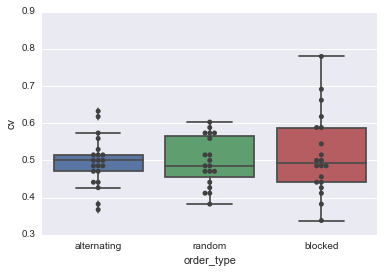

In [62]:
cv_data = []
for subj, orders in cv_scores.iteritems():
    for order, cv in orders.iteritems():
        cv_data.append([subj, order, cv])

cv_df = pd.DataFrame(cv_data, columns = ['subject_id', 'order_type', 'cv'])
ax = sns.boxplot(x="order_type", y="cv", data=cv_df)
ax = sns.swarmplot(x="order_type", y="cv", data=cv_df, color=".25")

# Save data frame to file
cv_df.to_csv('cross_validation_accuracy.csv')

cv_df.pivot_table(values = 'cv', index = 'order_type')

**Result:** The 2-fold cross-validation has worked as it should—overall, classification accuracies are not different from chance. However, classification accuracies are more *variable* for block orders than for alternating and random orders.

This is promising news: we have obtained valid results within our limited sample. It is important to note that these results are an important pre-requisite for estimating the type-I error rate of our analysis stream; however, given our limited sample size and number of simulations, it should not be interpreted as an estimate of the type-I error rate. In the conclusions below, I'll detail next steps to scale this method to obtain a more precise estimate of the type-I error rate.

## Conclusion

This notebook demonstrates initial steps towards building methods to test and validate analysis pipelines using Nipype. To summarize, the initial goal here was systematically vary aspects of the task design (specified using iterables), and search for false positives in a real, resting state dataset as a function of permutations of these parameters. In future iterations of this work, this basic method can be scaled to obtain an estimate of the false positive rate. In the meantime, two key contributions have been made in this initial version, which set the stage for future iterations of this work. First, the code above makes use of Nipype's unique abstractions to create arbitrary task models for each participant, thus allowing the user to search for false positives as a function of the task design. Second, the code above allows the user to create several 'iterations' of a model per subject for each permutation of parameters.

Becauss of limitations on computational resources, the latter feature is underutilized in this current implementation, but is key for obtaining an estimate of the type-I error rate. The goal, in future iterations of this code, is to use this feature to generate many models per subject, which can in turn be pooled over many group analyses, which in turn will provide a more precise estimate of the false positive rate.

In the meantime, there are several interesting engineering puzzles to solve in order to scale this method to support larger, iterated simulations. The most obvious consideration is storage: the resting state dataset used here (N = 25) is comparably small, and only a single simulation is run for each permutation of parameters. Therefore, the final results do not provide a precise estimate of the type-I error rate; to do so, we would need to scale our pipeline to run multiple simulations per subject per permutations of parameters, and aggregate over many random group analyses to obtain an estimate of the false positive rate. One way to reduce the demands on storage is to cache useful read-outs (e.g., cross-validation scores for each simulation) while discarding intermediate outputs (e.g., intermediate preprocessing steps, betas, contrast information). Though not shown here, this was a key factor for limiting the number of iterations here to 1—the amount of storage space used by each simulation quickly became unmanageable, even for a small number of simulations.

Nipype empowers users to create flexible and complex analysis pipelines using simple and compact syntax. This incredible flexibility also gives users the responsibility to check and validate their analysis methods. The present code provides initial scaffolding to estimate type-I error rates by analyzing 'null' resting-state data, and proposes next steps to scale this procedure for larger simulations.